# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

In [1]:
# ! pip install "tensorflow==1.14"

In [2]:
import sys
sys.path.append(r'C:\Users\Igor\PycharmProjects\SDC\hw2\frustum-pointnets')
import numpy as np
import tensorflow as tf
from train.test import get_session_and_ops, inference, write_detection_results
from PIL import Image
import os.path as path
import pandas as pd
from collections import namedtuple
from ssd import SSD

C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [3]:
import numpy as np
from matplotlib import pyplot as plt 

In [4]:
xyzi = np.fromfile('../kitti_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [5]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50, 50)

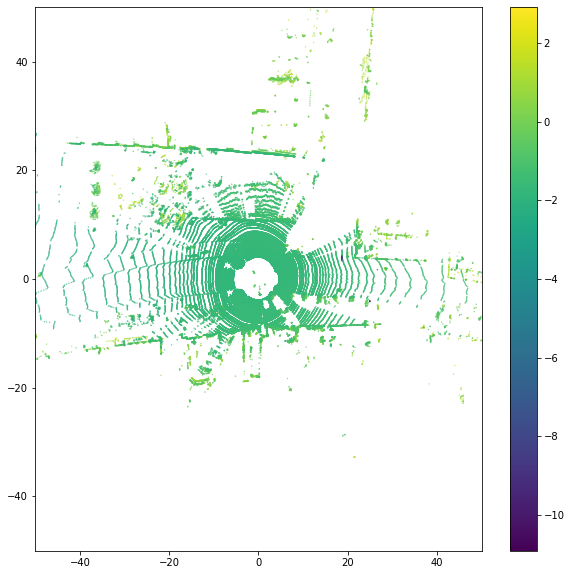

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [7]:
from PIL import Image

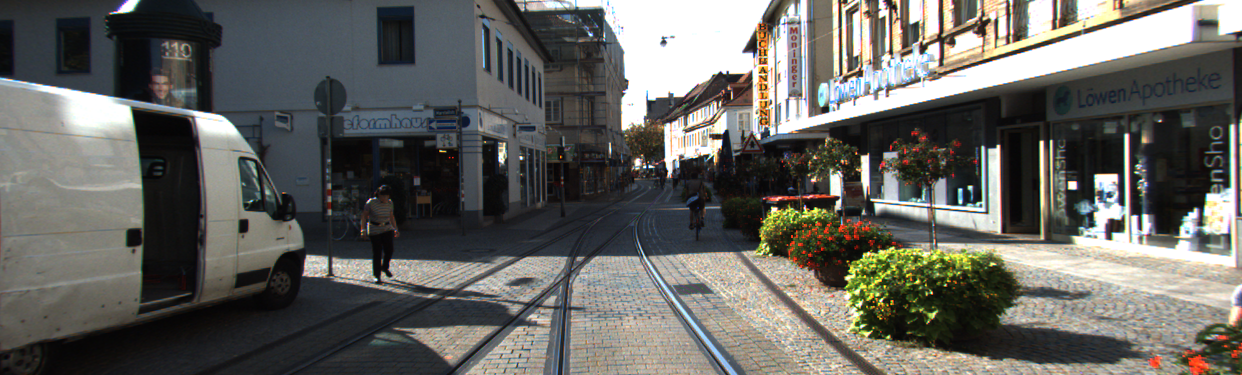

In [8]:
Image.open('../kitti_dataset/training/image_2/000100.png')

In [9]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print(f.read())

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [10]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print(f.read())

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10



In [11]:
Paths = namedtuple('Paths', ['calib', 'image_2', 'label_2', 'velodyne'])
def get_idx_paths(idx, kitty_path='../kitti_dataset/training'):
    dirs = [('calib', 'txt'), ('image_2', 'png'), ('label_2', 'txt'), ('velodyne', 'bin')]
    return Paths(*(path.join(kitty_path, d, f'{idx:0>6}.{ext}') for d, ext in dirs))

def get_calib_matrices(path):
    d = {}
    with open(path) as f:
        for line in f.readlines():
            line = line.strip().split(' ')
            if len(line) > 1:
                d[line[0].replace(':', '')] = np.array(line[1:], dtype=np.float32)
    P2 = d['P2'].reshape(3, 4)
    R0 = np.eye(4, 4)
    R0[:3, :3] = d['R0_rect'].reshape(3, 3)
    car_to_cam = np.eye(4, 4)
    car_to_cam[:3, :] = d['Tr_velo_to_cam'].reshape(3, 4)
    return car_to_cam, (P2, R0)

def get_data(idx):
    paths = get_idx_paths(idx)
    xyzi = np.fromfile(paths.velodyne, dtype=np.float32).reshape(-1, 4)
    img = np.array(Image.open(paths.image_2))
    label = pd.read_csv(paths.label_2, names=np.arange(15), sep=' ')
    calibs = get_calib_matrices(paths.calib)
    return (xyzi, img) + calibs + (label,)

In [12]:
get_data(100)

(array([[43.889,  0.084,  1.693,  0.   ],
        [43.201,  0.218,  1.67 ,  0.   ],
        [42.397,  0.347,  1.643,  0.   ],
        ...,
        [ 3.696, -1.398, -1.726,  0.31 ],
        [ 3.717, -1.399, -1.736,  0.35 ],
        [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32),
 array([[[ 35,  33,  35],
         [ 35,  33,  31],
         [ 35,  34,  30],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 35,  33,  34],
         [ 35,  33,  35],
         [ 36,  33,  35],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 36,  35,  33],
         [ 36,  35,  35],
         [ 36,  34,  37],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 12,   9,  10],
         [ 12,  10,   8],
         [ 12,   9,   7],
         ...,
         [ 24,  53,  48],
         [ 78,  68,  54],
         [102,  81,  48]],
 
        [[ 

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [13]:
detector = SSD(r'C:\Users\Igor\PycharmProjects\SDC\hw2\ssd')

In [14]:
def bbox_to_vertices(bbox):
    return np.array([bbox[0], [bbox[0, 0], bbox[1, 1]], bbox[1], [bbox[1, 0], bbox[0, 1]], bbox[0]])

In [17]:
image = get_data(50)[1]
detections = detector.predict(image)
detections

{'num_detections': 4,
 'detection_boxes': array([[0.47301343, 0.2062414 , 0.84572226, 0.38157484],
        [0.45694184, 0.51659817, 0.54969054, 0.5490241 ],
        [0.46639925, 0.72884333, 0.9969489 , 0.9929751 ],
        [0.45335543, 0.55077493, 0.68800884, 0.6482002 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        

In [18]:
def get_bboxes(image, detections):
    sh = np.array(image.shape)[:2]    
    plt.figure(figsize=(15, 5))
    plt.imshow(image)
    n = detections['num_detections']
    for box in detections['detection_boxes'][:n]:
        box = box.reshape(2,2)
        vertices = bbox_to_vertices(box * sh)
        plt.plot(vertices[:, 1], vertices[:, 0], c='g')
    plt.show()

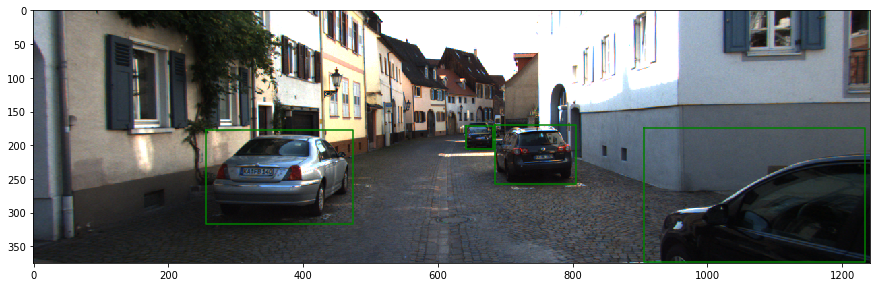

In [19]:
get_bboxes(image, detections)

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [20]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import tqdm
%matplotlib inline
py.init_notebook_mode(connected=True)

EQUAL_ASPECT_RATIO_LAYOUT = dict(
    margin={
        'l': 0,
        'r': 0,
        'b': 0,
        't': 0
    }, scene=dict(
    aspectmode='data'
))

def color(x, cmap='Reds'):
    cmap = plt.get_cmap(cmap)
    x = (x - np.min(x)) / np.max(x)
    
    return cmap(x)

In [28]:
Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

del(get_session_and_ops, inference, write_detection_results)
from train.test import get_session_and_ops, inference, write_detection_results

class PipelineDetector(object):
    def __init__(self, frustum_pointnet_version, frustum_batch_size, ssd_detector, ssd_threshold):
        self.frustum_pointnet_version, self.frustum_batch_size, self.ssd_detector, self.ssd_threshold = \
            frustum_pointnet_version, frustum_batch_size, ssd_detector, ssd_threshold
    
    def predict(self, xyzi, image, car_to_cam, intrinsics):
        print('Predicting bboxes...')
        prediction = self.ssd_detector.predict(image)
        shape = np.array(image.shape[:2] * 2)
        
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        n = prediction['num_detections']
        if n == 0: return
        boxes, classes, scores = prediction['detection_boxes'][:n], prediction['detection_classes'][:n], prediction['detection_scores'][:n]
        car_boxes = boxes[(classes == 1) & (scores > self.ssd_threshold)]
        if car_boxes.shape[0] == 0: 
            print('Car bboxes was not found.')
            return
        
        # TODO: process lidar point cloud and construct frustum examples
        print('Finding frustums...')
        P2, R0 = intrinsics
        transform = R0 @ car_to_cam
        xyz_homogen = xyzi.copy()
        xyz_homogen[:, 3] = 1.
        xyzi_rect = xyz_homogen @ transform.T
        xyzi_rect[:, 3] = xyzi[:, 3]
        xyw = xyz_homogen @ (P2 @ transform).T
        xy_cam = xyw[:, :2] / xyw[:, 2:]
        
        frustums = []
        for box in car_boxes:
            box *= shape # [0, 1] -> [0, width/height]
            in_box = (xyzi[:, 0] > 0) & (xy_cam[:, 1] > box[0]) & (xy_cam[:, 1] < box[2]) & (xy_cam[:, 0] > box[1]) & (xy_cam[:, 0] < box[3])
            frustums.append(in_box.nonzero()[0])
        
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        num_points = max(frustum.shape[0] for frustum in frustums)
        one_hot_vec = np.zeros((len(frustums), 3), dtype=int)
        one_hot_vec[:, 0] = 1
        pc = np.zeros((len(frustums), num_points, 4))
        for i, frustum in enumerate(frustums):
            pc[i, :frustum.shape[0], :] = xyzi_rect[frustum]
        sess, ops = get_session_and_ops(self.frustum_batch_size, num_points, self.frustum_pointnet_version)
        cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores = inference(sess, ops, pc, one_hot_vec, self.frustum_batch_size)
        
        # TODO: construct Scene namedtuple and return it
        return cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores
    
    def show_frustums(self, xyzi, image, car_to_cam, intrinsics):
        prediction = self.ssd_detector.predict(image)
        shape = np.array(image.shape[:2] * 2)
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        n = prediction['num_detections']
        if n == 0: return
        boxes, classes, scores = prediction['detection_boxes'][:n], prediction['detection_classes'][:n], prediction['detection_scores'][:n]
        car_boxes = boxes[(classes == 1) & (scores > self.ssd_threshold)]
        plt.figure(figsize=(20, 10))
        plt.imshow(image)
        if car_boxes.shape[0] == 0: 
            plt.show()
            return
        # TODO: process lidar point cloud and construct frustum examples
        P2, R0 = intrinsics
        transform = R0 @ car_to_cam
        xyz_homogen = xyzi.copy()
        xyz_homogen[:, 3] = 1.
        xyzi_rect = xyz_homogen @ transform.T
        xyzi_rect[:, 3] = xyzi[:, 3]
        xyw = xyzi_rect @ P2.T
        xy_cam = xyw[:, :2] / xyw[:, 2:]
        
        r = np.linalg.norm(xyzi[:, :2], axis=1)        
        frustums = []
        rs = []
        for box in car_boxes:
            box *= shape # [0, 1] -> [0, width/height]
            in_box = (xyzi[:, 0] > 2) & (xy_cam[:, 1] > box[0]) & (xy_cam[:, 1] < box[2]
                                                                  ) & (xy_cam[:, 0] > box[1]) & (xy_cam[:, 0] < box[3])
            in_box = in_box.nonzero()[0]
            frustums.append(in_box)
            rs.append(np.log1p(r[in_box]))
            plt.scatter(xy_cam[in_box, 0], xy_cam[in_box, 1], c=np.log1p(r[in_box]), s=1)
            
        plt.show()
        
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        num_points = 1024 # max(frustum.shape[0] for frustum in frustums)
        frustums = [np.random.choice(frustum, num_points, replace=(False if frustum.shape[0] >= num_points else True)) for frustum in frustums]
        one_hot_vec = np.zeros((len(frustums), 3), dtype=bool)
        one_hot_vec[:, 0] = 1
        pc_rect = np.zeros((len(frustums), num_points, 4))
        pc = np.zeros((len(frustums), num_points, 4))
        for i, frustum in enumerate(frustums):
            pc_rect[i, :frustum.shape[0], :] = xyzi_rect[frustum]
            pc[i, :frustum.shape[0], :] = xyzi[frustum]
        sess, ops = get_session_and_ops(pc.shape[0], num_points, self.frustum_pointnet_version)
        cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores = inference(sess, ops, pc_rect, one_hot_vec, pc.shape[0])
        
        scene = pc.reshape((-1, 4))
        colors = np.hstack(rs)
        fig = go.Figure(layout=EQUAL_ASPECT_RATIO_LAYOUT)
        fig.add_scatter3d(**{
            'x': scene[:, 0],
            'y': scene[:, 1],
            'z': scene[:, 2],
            'mode': 'markers',
            'marker': {
                'size': 1,
                'color': color(cls.reshape(-1), 'seismic')
            },
            'text': cls.reshape(-1)
        })

        py.iplot(fig)
        return cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [29]:
pipeline = PipelineDetector('v1', 1, detector, 0.7)
idx = 10

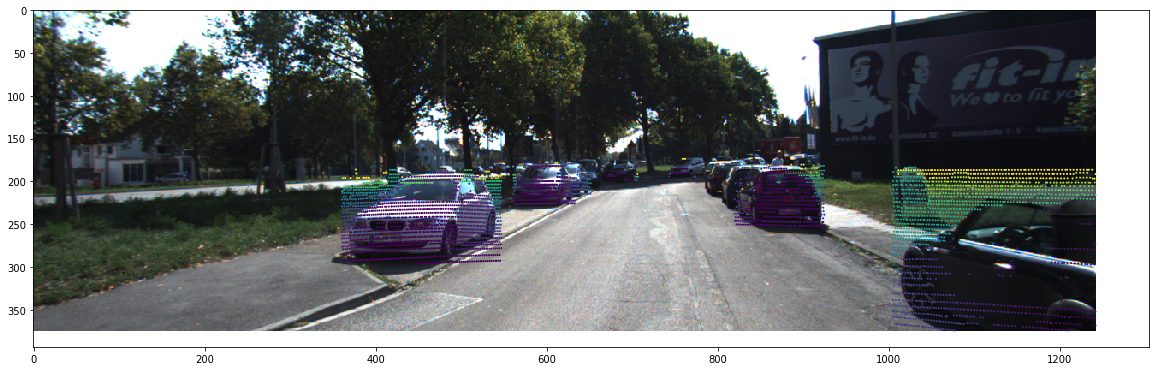

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from C:\Users\Igor\PycharmProjects\SDC\hw2\frustum_pointnets_snapshots\log_v1\model.ckpt


In [30]:
cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores = pipeline.show_frustums(*(get_data(idx)[:-1]))

In [31]:
cls, centers, heading_cls, heading_res, \
           size_cls, size_res, scores

(array([[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[ 1.07966578,  0.91676831, 12.72063446],
        [-0.3804692 ,  0.96390009, 23.628479  ],
        [ 0.55406952,  1.13126051,  7.68620062],
        [ 0.48888731,  0.98355883, 29.0152874 ],
        [-0.10671332,  0.56589818, 15.99589539],
        [ 0.5856815 ,  0.43909207, 15.11395264],
        [-3.19341516,  0.9143284 , 13.8431282 ]]),
 array([0, 3, 0, 3, 6, 6, 8], dtype=int64),
 array([ 0.00304801,  0.19754732,  0.00726179,  0.18149909,  0.05542668,
         0.21790908, -0.0392028 ]),
 array([0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[ 0.34383723,  0.02412863,  0.16497557],
        [-0.00782796,  0.01785364,  0.00869408],
        [ 0.24796216,  0.04810746,  0.01161854],
        [ 0.02309364, -0.00159154, -0.04335144],
        [-0.10449559, -0.01911313,  

Ничего не работает :( Памагити!

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.